Tutorial: https://www.youtube.com/watch?v=GYDFBfx8Ts8&ab_channel=JamesBriggs

Challenge: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews  
The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee [1]. In their work on sentiment treebanks, Socher et al. [2] used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.


Use transfer learning from BERT model to predict sentiment from sentences. This is a multi-class classification problem using both TensorFlow and Transformers to build a multiclass sentiment classifier.

1 - Download and preprocess Data  
2 - Initializing hugging face (transformers framework) Tokenizer and Model  
3 - Encode Input Data  
4 - Build Model architecture (Input layers --> BERT output layers)  
5 - Optimizers, Metrics and Loss  
6 - Training

# Load and arrange data

In [10]:
# download data from kaggle (https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
# users need to accept rules
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'train.tsv.zip', path='./')

100%|██████████| 1.28M/1.28M [00:00<00:00, 10.7MB/s]

In [4]:
import zipfile
with zipfile.ZipFile('train.tsv.zip','r') as zipref:
    zipref.extractall('./')

In [7]:
import pandas as pd
df = pd.read_csv('train.tsv', sep='\t')
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [8]:
# choose only full sentence - first element of every unique sentence ID
df.drop_duplicates(subset='SentenceId', keep='first', inplace=True)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


In [9]:
len(df)

8529

### Decide on sequence length

In [48]:
seqlen = df['Phrase'].apply(lambda x: len(x.split()))

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1600x1000 with 0 Axes>

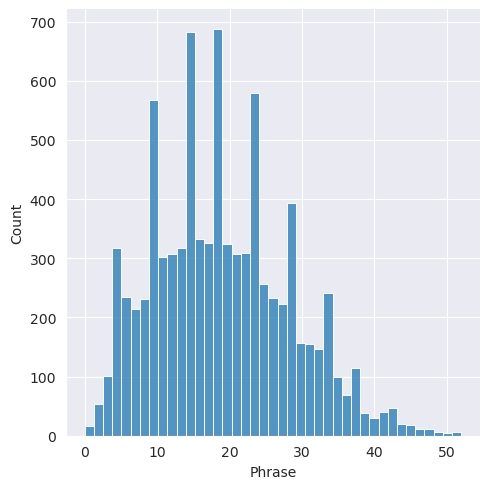

In [50]:
sns.set_style('darkgrid')
plt.figure(figsize=(16,10))
sns.displot(seqlen)

Decide on length 50 just that we have as much data as possible

In [1]:
SEQ_LEN = 50

### Initialize tokenizer
BERT model + BERT tokenizer

In [2]:
from transformers import AutoTokenizer

/users/bernardo.almeida/miniconda3/envs/Practice_tf_gpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-15 09:11:57.706430: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased') # case means that bert distinguiches difference between upper case and lower case

In [4]:
tokens = tokenizer.encode_plus('hello world', max_length=SEQ_LEN, # hardcoded a single line with hello world to initialize. Defined max length
                               truncation=True, padding='max_length', # truncate longer sequences and padd short sequences
                               add_special_tokens=True, return_token_type_ids=False, # add special tokens (start and end of sentence). We dont token_type_ids
                               return_attention_mask=True, return_tensors='tf') # we need attention_mask. Because we are working in tensorflow we need to return tensors

2022-11-15 09:12:04.637041: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-15 09:12:04.652282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-15 09:12:04.873426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 09:12:04.873804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:06.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2022-11-15 09:12:04.873845: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-15 09:12:04.893152: I tensorflow/stream_executor/platform/def

In [5]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[  101, 19082,  1362,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [10]:
# tokenize all sequences in dataset
import numpy as np
Xids = np.zeros((len(df), SEQ_LEN))
Xmask = np.zeros((len(df), SEQ_LEN))
Xids.shape

(8529, 50)

In [11]:
# we are only processing the encding of this dataset one time -> we will save it and load it from memory during training
for i, sequence in enumerate(df['Phrase']):
    tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, # hardcoded a single line with hello world to initialize. Defined max length
                               truncation=True, padding='max_length', # truncate longer sequences and padd short sequences
                               add_special_tokens=True, return_token_type_ids=False, # add special tokens (start and end of sentence). We dont token_type_ids
                               return_attention_mask=True, return_tensors='tf') # we need attention_mask. Because we are working in tensorflow we need to return tensors
    Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

In [12]:
Xids

array([[ 101.,  138., 1326., ...,    0.,    0.,    0.],
       [ 101., 1188., 3589., ...,    0.,    0.,    0.],
       [ 101., 2431., 3899., ...,    0.,    0.,    0.],
       ...,
       [ 101.,  118.,  149., ...,    0.,    0.,    0.],
       [ 101., 1109., 2523., ...,    0.,    0.,    0.],
       [ 101., 1109., 1273., ...,    0.,    0.,    0.]])

In [13]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

### One-hot encode labels

In [14]:
df['Sentiment'].unique()

array([1, 4, 3, 2, 0])

In [15]:
arr = df['Sentiment'].values
arr.size

8529

In [16]:
labels = np.zeros((arr.size, arr.max()+1))
labels.shape

(8529, 5)

In [17]:
# add ones to the indices where we have a value
labels[np.arange(arr.size), arr] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

### Save data

In [61]:
with open('xids.npy', 'wb') as f:
    np.save(f, Xids)
with open('xmask.npy', 'wb') as f:
    np.save(f, Xmask)
with open('labels.npy', 'wb') as f:
    np.save(f, labels)

del df, Xids, Xmask, labels # remove from memory

In [5]:
# for loading
with open('xids.npy', 'rb') as fp:
    Xids = np.load(fp)
with open('xmask.npy', 'rb') as fp:
    Xmask = np.load(fp)
with open('labels.npy', 'rb') as fp:
    labels = np.load(fp)

In [18]:
Xids

array([[ 101.,  138., 1326., ...,    0.,    0.,    0.],
       [ 101., 1188., 3589., ...,    0.,    0.,    0.],
       [ 101., 2431., 3899., ...,    0.,    0.,    0.],
       ...,
       [ 101.,  118.,  149., ...,    0.,    0.,    0.],
       [ 101., 1109., 2523., ...,    0.,    0.,    0.],
       [ 101., 1109., 1273., ...,    0.,    0.,    0.]])

### Convert arrays into tensorflow dataset objects
Because it makes it easier to rearrange data, shuffling and batching our dataset

In [19]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels)) # creates a generetaor that contains all data in the tupple-like format

In [21]:
for i in dataset.take(1):
    print(i)

(<tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,   138.,  1326.,  1104., 13936., 25265., 16913., 15107.,
        1103.,  8050.,  2553.,  1115.,  1184.,  1110.,  1363.,  1111.,
        1103., 20398.,  1110.,  1145.,  1363.,  1111.,  1103.,   176.,
        9900.,   117.,  1199.,  1104.,  1134.,  5411.,  1821., 14225.,
        1133.,  3839.,  1104.,  1134.,  7919.,  1106.,  1277.,  1104.,
         170.,  1642.,   119.,   102.,     0.,     0.,     0.,     0.,
           0.,     0.])>, <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])>, <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0., 1., 0., 0., 0.])>)


In [22]:
# Create data structure
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [23]:
dataset = dataset.map(map_func)

In [24]:
for i in dataset.take(1):
    print(i)
# Input dictionary {input IDs, input attention masks} + output labels

({'input_ids': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,   138.,  1326.,  1104., 13936., 25265., 16913., 15107.,
        1103.,  8050.,  2553.,  1115.,  1184.,  1110.,  1363.,  1111.,
        1103., 20398.,  1110.,  1145.,  1363.,  1111.,  1103.,   176.,
        9900.,   117.,  1199.,  1104.,  1134.,  5411.,  1821., 14225.,
        1133.,  3839.,  1104.,  1134.,  7919.,  1106.,  1277.,  1104.,
         170.,  1642.,   119.,   102.,     0.,     0.,     0.,     0.,
           0.,     0.])>, 'attention_mask': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])>}, <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0., 1., 0., 0., 0.])>)


2022-11-15 09:12:48.844928: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-15 09:12:48.846112: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3192495000 Hz


In [25]:
# shuffle and put samples into batches of 32
dataset = dataset.shuffle(100000).batch(32)

In [26]:
# split into training and validation set
DS_LEN = len(list(dataset))
DS_LEN

267

In [27]:
SPLIT = 0.9 # train/val split

train = dataset.take(round(DS_LEN*SPLIT)) # select these
val = dataset.skip(round(DS_LEN*SPLIT)) # skip these

del dataset

# Build model architecture

In [28]:
# initialize BERT
from transformers import TFAutoModel
# had to correct keras loading (https://github.com/huggingface/transformers/issues/18912)
bert = TFAutoModel.from_pretrained('bert-base-cased') # same model used to initialie tokenizer

2022-11-15 09:12:52.871379: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
# Define input layers: 2 --> input IDs and input attention mask
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32') # name is very important - needs to match the dictionary names
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

# pull the embeddings from the initialized BERT model
# bert will return 2 tensors:  1) last hidden-state, which is what we are interested in, 3D tensor with all information from last hidden-state. 2) puller output: after runing it through a FF and linear activation and pooled, 2D densor that can be used to classification (ignre)
embeddings = bert(input_ids, attention_mask=mask)[0]

# now you can experiment with adding any lstm layers, CNNs, or anything else
# we will keep it simple and add a gloabl maxpooling layer - converting 3D to 2D tensor
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
# normalize outputs
X = tf.keras.layers.BatchNormalization()(X)

# Fully Connected layers in charge of the classification
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation='relu')(X)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the bert model to don't train it
model.layers[2].trainable = False

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]          

In [31]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

EPOCHS = 10 # only for testing - run full model as job
checkpoint_filepath = 'my_best_model.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model training

In [32]:
# fit the model
history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback]
)    

Epoch 1/10
240/240 [==============================] - 34s 103ms/step - loss: 1.6220 - accuracy: 0.3263 - val_loss: 1.3372 - val_accuracy: 0.4040
Epoch 2/10
240/240 [==============================] - 22s 92ms/step - loss: 1.3517 - accuracy: 0.4104 - val_loss: 1.2810 - val_accuracy: 0.4240
Epoch 3/10
240/240 [==============================] - 22s 92ms/step - loss: 1.3234 - accuracy: 0.4089 - val_loss: 1.2548 - val_accuracy: 0.4346
Epoch 4/10
240/240 [==============================] - 22s 92ms/step - loss: 1.3113 - accuracy: 0.4196 - val_loss: 1.2910 - val_accuracy: 0.4181
Epoch 5/10
240/240 [==============================] - 22s 92ms/step - loss: 1.3071 - accuracy: 0.4226 - val_loss: 1.2165 - val_accuracy: 0.4711
Epoch 6/10
240/240 [==============================] - 22s 92ms/step - loss: 1.3008 - accuracy: 0.4197 - val_loss: 1.1811 - val_accuracy: 0.4900
Epoch 7/10
240/240 [==============================] - 24s 101ms/step - loss: 1.2755 - accuracy: 0.4341 - val_loss: 1.2564 - val_accurac

Expected 140 epoch performance
loss: 0.49, acc: 0.82; val_loss: 0.21, val_acc: 0.94

In [109]:
# Save model
model.save('Model_BERT_final_class.h5')
# Save history
np.save('Model_BERT_final_class_history.npy',history.history) 
# history=np.load('Model_BERT_final_class_history.npy',allow_pickle='TRUE').item()

# Model evaluation

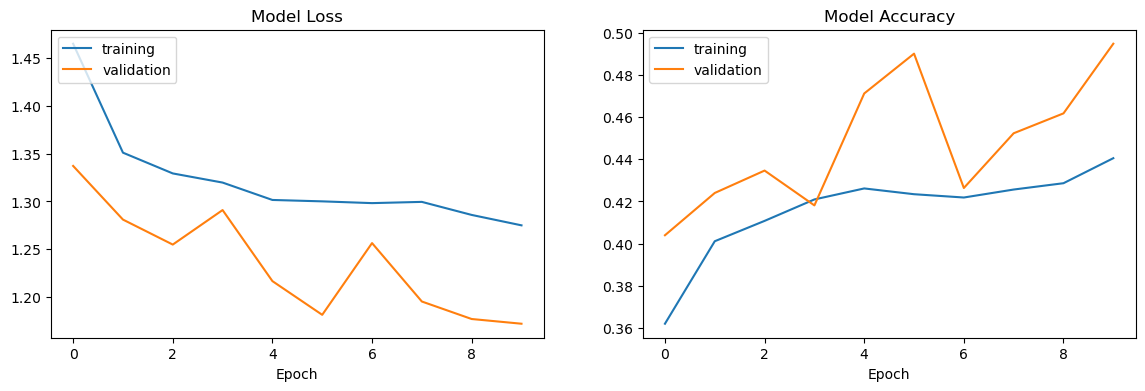

In [33]:
import matplotlib.pyplot as plt

# plot history
plt.ion()
fig = plt.figure(figsize=(14,4))
subfig = fig.add_subplot(122)
subfig.plot(history.history['accuracy'], label="training")
if history.history['val_accuracy'] is not None:
    subfig.plot(history.history['val_accuracy'], label="validation")
subfig.set_title('Model Accuracy')
subfig.set_xlabel('Epoch')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(121)
subfig.plot(history.history['loss'], label="training")
if history.history['val_loss'] is not None:
    subfig.plot(history.history['val_loss'], label="validation")
subfig.set_title('Model Loss')
subfig.set_xlabel('Epoch')
subfig.legend(loc='upper left')
plt.ioff()
plt.savefig('Model_BERT_final_class_performance.pdf')  

# Model testing

In [90]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
SEQ_LEN = 50
def create_test(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_attention_mask=True, return_tensors='tf')
    return tokens

def sentiment_pred(seq):
    pred = model.predict([create_test(seq)['input_ids'], create_test(seq)['attention_mask']])[0]
    # convert class
    print(seq + ' --> ' + str(np.where(pred == np.amax(pred))[0][0]) + ' stars')

In [93]:
# test some sentences
sentences = ['This is shit',
             'This is bad',
             'This is poor',
             'This is not too bad',
             'This is okay',
             'This is good',
             'This is interesting',
             'This is fine',
             'This is excelent',
             'This is great',
             'This is amazing',
             'This is the best ever',
             'I love it!!!',
             
             'I hated this movie',
             'It had a very interesting story',
             'It had a very interesting story but I did not like the actors',
             'I did not like the actors',
            
             'I love you']

for s in sentences:
    sentiment_pred(s)

This is shit --> sentiment: 0 stars
This is bad --> sentiment: 0 stars
This is poor --> sentiment: 0 stars
This is not too bad --> sentiment: 2 stars
This is okay --> sentiment: 2 stars
This is good --> sentiment: 2 stars
This is interesting --> sentiment: 1 stars
This is fine --> sentiment: 3 stars
This is excelent --> sentiment: 3 stars
This is great --> sentiment: 3 stars
This is amazing --> sentiment: 4 stars
This is the best ever --> sentiment: 4 stars
I love it!!! --> sentiment: 4 stars
I hated this movie --> sentiment: 0 stars
It had a very interesting story --> sentiment: 4 stars
It had a very interesting story but I did not like the actors --> sentiment: 1 stars
I did not like the actors --> sentiment: 1 stars
